In [ ]:
!pip install pandas numpy gensim spacy matplotlib pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 36.9 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Topic 1: 0.073*"application" + 0.043*"good" + 0.030*"use" + 0.024*"information" + 0.023*"watch" + 0.019*"useful" + 0.017*"app" + 0.016*"simple" + 0.012*"bluetooth" + 0.012*"data"
Topic 2: 0.049*"app" + 0.033*"application" + 0.023*"activate" + 0.019*"works" + 0.013*"problem" + 0.013*"time" + 0.012*"work" + 0.012*"phone" + 0.012*"impossible" + 0.012*"update"
Topic 3: 0.016*"covid" + 0.014*"application" + 0.014*"good" + 0.014*"app" + 0.013*"people" + 0.012*"little" + 0.012*"work" + 0.011*"like" + 0.009*"new" + 0.009*"available"
Topic 4: 0.045*"update" + 0.034*"app" + 0.029*"vaccination" + 0.024*"certificate" + 0.022*"load" + 0.021*"code" + 0.017*"use" + 0.016*"install" + 0.015*"phone" + 0.014*"certificates"
Topic 5: 0.042*"code" + 0.033*"application" + 0.027*"step" + 0.022*"scan" + 0.021*"contact" + 0.021*"sanitary" + 0.014*"app" + 0.014*"case" + 0.013*"days" + 0.013*"positive"
   sentiment_label  topic  count
0         Negative      0    341
1         Negative      1    864
2         Neg

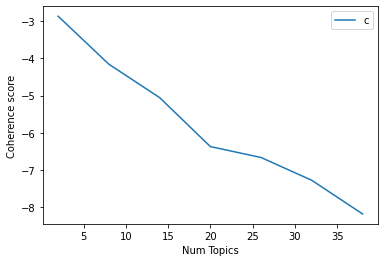

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


                                     translated_comment sentiment_label  \
0     Excellent app no advertising quite long lifesp...        Positive   
1     The first immediately visible advantage plus t...        Positive   
2     These games are great there are plenty of poss...        Positive   
3     Why require all notifications to be activated ...         Neutral   
4     A little lost in this really vast open world A...        Positive   
...                                                 ...             ...   
9708     Ultra simple I scan easily And Im 76 years old        Positive   
9709               How do we get only one phone for two         Neutral   
9710                              Super good and useful        Positive   
9711  I had problems at first but now its at the top...        Positive   
9712  Super good walking attestations and scans are ...        Positive   

     topic_label  
0        Topic 2  
1        Topic 1  
2        Topic 2  
3        Topic 1  
4   

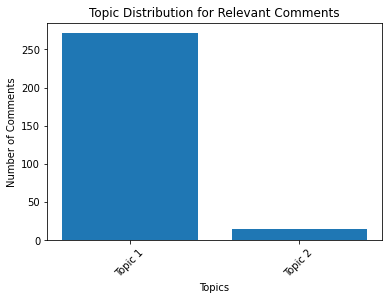

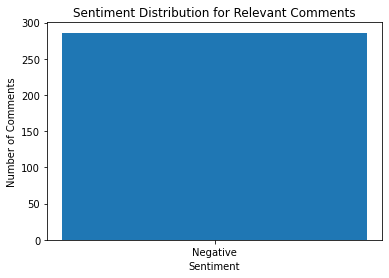

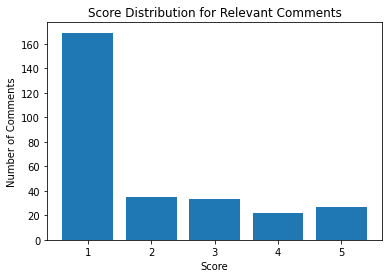

Common words for Topic 1: app, application, code, work, use, phone, activate, bluetooth, time, contact
Common words for Topic 2: application, good, update, watch, certificate, step, information, vaccination, useful, new


In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models, similarities, utils
from gensim.models import CoherenceModel, LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser
import spacy
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from multiprocessing import Pool
import nltk
nltk.download('punkt')
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
                        
# Load dataset
data = pd.read_csv("/content/drive/MyDrive/masterthesis/translated_reviews_sentiments.csv")
filter = ['ive', 'dont', 'got', 'youre', 'doesnt', 'game', 'dont', 'lets', 'thank', 'sea', 'mrs'] # manual filter after analyzing first results with only STOPWORDS OUT
# Prepare data for topic modeling
# Prepare data for topic modeling
def prepare_data(data):
    reviews = data["translated_comment"].tolist()
    
    # Detect and merge bigrams using NLTK
    tokenized_reviews = [nltk.word_tokenize(review.lower()) for review in reviews]
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_documents(tokenized_reviews)
    finder.apply_freq_filter(10)
    bigram_phrases = finder.nbest(bigram_measures.pmi, 500)
    bigram_transformer = Phrases(bigram_phrases)

    # Add bigram phrases to the tokenizer
    bigram_transformer = Phrases(bigram_phrases)
    tokenized_reviews = [bigram_transformer[review] for review in tokenized_reviews]
    
    # Remove stop words and filter out rare and common words
    tokenized_reviews = [[word for word in review if word not in STOPWORDS and word not in filter and len(word) > 2 and not word.isdigit()] for review in tokenized_reviews]
    dictionary = Dictionary(tokenized_reviews)
    dictionary.filter_extremes(no_below=10, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]
    
    return corpus, dictionary, tokenized_reviews


corpus, dictionary, tokenized_reviews = prepare_data(data)

# Perform LDA topic modeling
def topic_modeling_lda(corpus, dictionary, num_topics):
    lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, iterations=100, passes=10, workers=2)
    
    return lda_model

num_topics = 5
lda_model = topic_modeling_lda(corpus, dictionary, num_topics)

# Print topics
for i, topic in lda_model.print_topics(-1):
    print(f"Topic {i + 1}: {topic}")

# Perform NER
def named_entity_recognition(texts):
    nlp = spacy.load("en_core_web_sm")
    named_entities = []

    for text in texts:
        doc = nlp(text)
        for ent in doc.ents:
            named_entities.append((ent.text, ent.label_))
            
    return named_entities

named_entities = named_entity_recognition(data["translated_comment"])

# Analyze data
def analyze_data(data, lda_model, corpus, named_entities):
    # Add topics to the dataset
    data["topic"] = [sorted(lda_model.get_document_topics(corpus[i]), key=lambda x: -x[1])[0][0] for i in range(len(corpus))]
    
    # Add named entities to the dataset
    data["named_entities"] = ', '.join([f"{ent[0]} ({ent[1]})" for ent in named_entities])

    # Group by sentiment_label and topic to identify common concerns and feedback
    grouped_data = data.groupby(["sentiment_label", "topic"]).size().reset_index(name="count")

    return grouped_data

grouped_data = analyze_data(data, lda_model, corpus, named_entities)
print(grouped_data)

# Save the results to a new CSV file
data.to_csv("translatedreviews_sentiments_with_topics.csv", index=False)

# Calculate coherence scores for different number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        try:
            model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, iterations=150, alpha='auto')
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
            print("+1 itération")
        except ValueError:
            print(f"Skipping num_topics={num_topics} due to empty vocabulary")
            continue

    return model_list, coherence_values
    
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_reviews, start=2, limit=40, step=6)

# Plot the coherence scores
plt.plot(range(2, 40, 6), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Train the LDA model with the best number of topics
best_num_topics = np.argmax(coherence_values) * 6 + 2
best_lda_model = model_list[np.argmax(coherence_values)]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Save the LDA model visualization to a file
pyLDAvis.save_html(vis, 'lda_model_visualization.html')

# Combine the sentiment analysis with the topic modeling
topic_sentiments = []
for comment in data['translated_comment']:
    bow = dictionary.doc2bow(gensim.utils.simple_preprocess(comment))
    topic_probs = best_lda_model.get_document_topics(bow)
    topic_sentiments.append(max(topic_probs, key=lambda x: x[1])[0])

data['topic'] = topic_sentiments
data['topic_label'] = data['topic'].apply(lambda x: 'Topic ' + str(x + 1))

print(data[['translated_comment', 'sentiment_label', 'topic_label']])

# Filter comments with negative sentiment and linked to privacy concerns
def is_privacy_concern(comment):
    privacy_keywords = ['privacy', 'personal data', "tracing", "bluetooth", "ROBERT", "GDPR"]
    for keyword in privacy_keywords:
        if keyword in comment.lower():
            return True
    return False

data_privacy_neg = data[(data['sentiment_label'] == 'Negative') & (data['translated_comment'].apply(is_privacy_concern))]

# Display the most relevant comments
print(data_privacy_neg[['translated_comment', 'sentiment_label', 'topic_label']])

# Save the most relevant comments to a CSV file
data_privacy_neg.to_csv('relevant_comments.csv', index=False)

# Visualize the distribution of topics for relevant comments
topic_counts = data_privacy_neg['topic_label'].value_counts()
plt.bar(topic_counts.index, topic_counts.values)
plt.xlabel('Topics')
plt.ylabel('Number of Comments')
plt.title('Topic Distribution for Relevant Comments')
plt.xticks(rotation=45)
plt.show()

# Visualize the distribution of sentiment scores for relevant comments
sentiment_counts = data_privacy_neg['sentiment_label'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution for Relevant Comments')
plt.show()

# Analyze the distribution of scores for relevant comments
score_counts = data_privacy_neg['score'].value_counts().sort_index()
plt.bar(score_counts.index, score_counts.values)
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.title('Score Distribution for Relevant Comments')
plt.xticks(range(1, 6))
plt.show()

# Function to display the most common words for a specific topic
def display_common_words(topic_num, num_words=10):
    topic_terms = best_lda_model.show_topic(topic_num, topn=num_words)
    words = [term[0] for term in topic_terms]
    print(f"Common words for Topic {topic_num + 1}: {', '.join(words)}")

# Display the most common words for each topic
for i in range(best_num_topics):
    display_common_words(i)

In [ ]:
print(coherence_values)
print(model_list)

[0.40390643986481023, 0.48777124939923544, 0.43436257402910694, 0.4034073300246585, 0.42582599004540145, 0.42035250634029087, 0.40438324235953366]
[<gensim.models.ldamodel.LdaModel object at 0x7f52a45d25b0>, <gensim.models.ldamodel.LdaModel object at 0x7f528833f6a0>, <gensim.models.ldamodel.LdaModel object at 0x7f52a5da06d0>, <gensim.models.ldamodel.LdaModel object at 0x7f52a08855e0>, <gensim.models.ldamodel.LdaModel object at 0x7f52a15edaf0>, <gensim.models.ldamodel.LdaModel object at 0x7f528f6031c0>, <gensim.models.ldamodel.LdaModel object at 0x7f52a5daa190>]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to the directory in your Google Drive where you want to upload the files
drive_path = '/content/drive/MyDrive/masterthesis/Topic_modeling_analysis/'

# Upload the files to your Google Drive
!cp /content/lda_model_visualization.html "{drive_path}"
!cp /content/relevant_comments.csv "{drive_path}"
#!cp /content/translatedreviews_sentiments_with_topics.csv "{drive_path}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the relevant_comments.csv file
df = pd.read_csv('/content/drive/MyDrive/masterthesis/Topic_modeling_analysis/relevant_comments.csv')

# Select only the columns we want
df_new = df[['topic', 'preprocessed_comment', 'translated_comment']]

# Save the new file to disk
df_new.to_csv('new_relevant_comments.csv', index=False)

In [ ]:
# Read the new CSV file with selected columns
df = pd.read_csv('/content/new_relevant_comments.csv', usecols=['topic', 'preprocessed_comment'])

# filter the dataframe to only include rows with topics 1, 3, or 7
filtered_df = df[df['topic'].isin([1, 3, 7])]

# select only the 'preprocessed_comment' column
comments = filtered_df['preprocessed_comment']

# write the comments to a text file
with open('comments.txt', 'w') as f:
    for comment in comments:
        f.write(comment + '\n')